## GMM
* GMM(Gaussian Mixture Model): 다변량 정규분포의 밀도함수를 적절히 합친 것

## EM 알고리즘
* EM: Expectation-step + Maximization-step
* EM 알고리즘은 잠재변수 또는 결측값이 있을 때를 상정하여 만든 최대가능도 기반 알고리즘으로 잠재변수나 결측 데이터가 있을 때 유용

## 군집화

### GMM 실습

* 시뮬레이션 데이터 생성

Text(0.5, 1.0, 'transformed data')

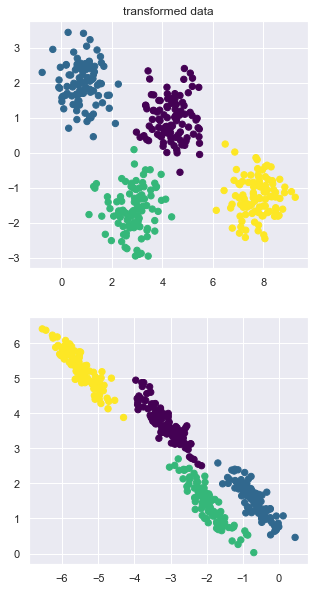

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture

from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, 
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1]

rng = np.random.RandomState(13)
X_trans = np.dot(X, rng.randn(2, 2))

figure, axes = plt.subplots(2, figsize=(5, 10))
axes[0].scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis')
axes[0].set_title('original data')
axes[1].scatter(X_trans[:, 0], X_trans[:, 1], c=y_true, s=40, cmap='viridis')
axes[0].set_title('transformed data')

* 정규분포별 contour plot을 생성하는 함수

In [2]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2*np.sqrt(s)
    else:
        angle = 0
        width, height = 2*np.sqrt(covariance)
        
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig*width, nsig*height, angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    if gmm.covariances_.shape == (2, 2):
        gmm.covariances_ = np.repeat(gmm.covariances_[np.newaxis, :, :], 4, axis=0)
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        if covar.size == 1:
            n_features = gmm.means_.shape[1]
            covar = np.repeat(covar, n_features)
        draw_ellipse(pos, covar, ax=ax, alpha=w*w_factor)

* 원본 데이터와 변형 데이터에 GMM 적용

Text(0.5, 1.0, 'transformed data, fitted')

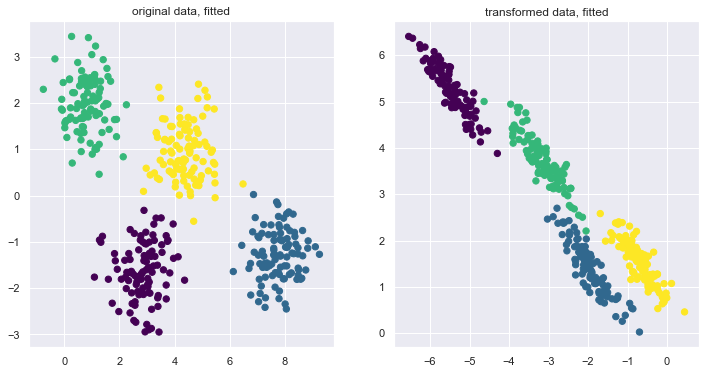

In [3]:
gmm = GaussianMixture(n_components=4)
gmm_trans = GaussianMixture(n_components=4)
labels = gmm.fit(X).predict(X)
labels_trans = gmm_trans.fit(X_trans).predict(X_trans)

figure, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
axes[0].set_title("original data, fitted")
axes[1].scatter(X_trans[:, 0], X_trans[:, 1], c=labels_trans, s=40, cmap='viridis')
axes[1].set_title("transformed data, fitted")

* 성능 평가

Text(0.5, 1.0, 'transformed data, kmeans, API = 1.0')

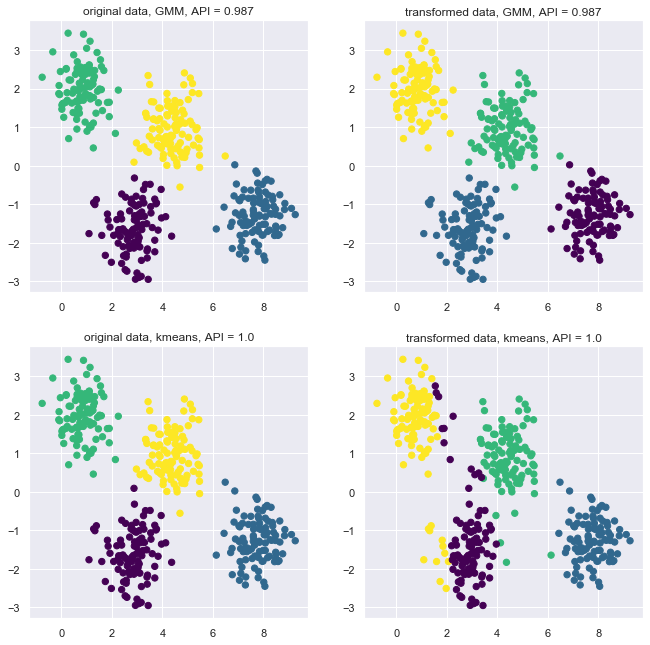

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=4)
kmeans_trans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit(X).predict(X)
kmeans_labels_trans = kmeans_trans.fit(X_trans).predict(X_trans)

figure, axes = plt.subplots(2, 2, figsize=(11, 11))
axes[0, 0].scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
axes[0, 0].set_title("original data, GMM, API = " +
                     str(round(adjusted_rand_score(y_true, labels), 3)))
axes[0, 1].scatter(X[:, 0], X[:, 1], c=labels_trans, s=40, cmap='viridis')
axes[0, 1].set_title("transformed data, GMM, API = " +
                     str(round(adjusted_rand_score(y_true, labels), 3)))
axes[1, 0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, s=40, cmap='viridis')
axes[1, 0].set_title("original data, kmeans, API = " +
                     str(round(adjusted_rand_score(y_true, kmeans_labels), 3)))
axes[1, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels_trans, s=40, cmap='viridis')
axes[1, 1].set_title("transformed data, kmeans, API = " +
                     str(round(adjusted_rand_score(y_true, kmeans_labels), 3)))

* 공분산 행렬 조건

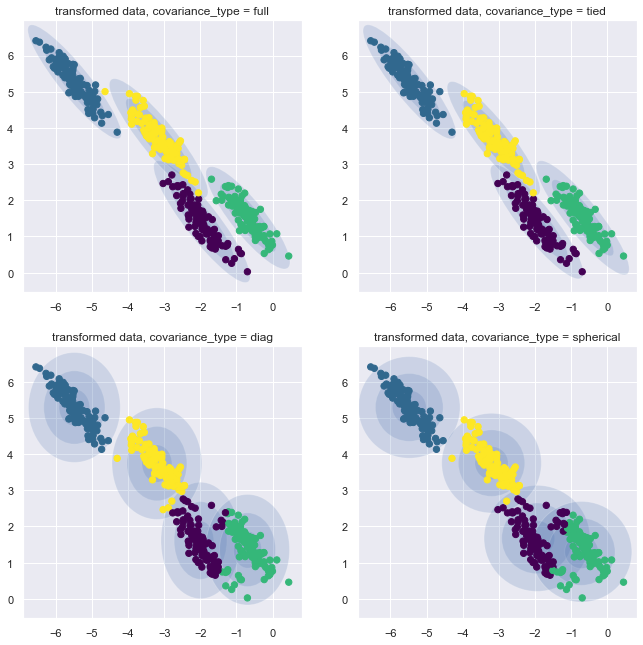

In [5]:
figure, axes = plt.subplots(2, 2, figsize=(11, 11))
for k, cov_type in enumerate(['full', 'tied', 'diag', 'spherical']):
    j = (k) % 2
    i = (k-j) // 2 % 2
    gmm = GaussianMixture(n_components=4, covariance_type=cov_type, random_state=0)
    plot_gmm(gmm, X_trans, ax=axes[i, j])
    axes[i, j].set_title("transformed data, covariance_type = " + cov_type)

## 모형 선택 방법론

* AIC, BIC를 이용한 최적 GMM 선택

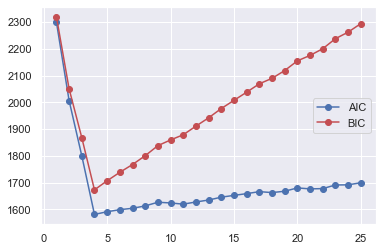

In [6]:
AIC = []
BIC = []
max_components = 25
for comp in range(max_components):
    gmm = GaussianMixture(n_components=comp+1, random_state=0).fit(X_trans)
    AIC.append(gmm.aic(X_trans))
    BIC.append(gmm.bic(X_trans))
    
plt.plot(range(1, 26), AIC, marker='o', label='AIC', color='b')
plt.plot(range(1, 26), BIC, marker='o', label='BIC', color='r')
plt.legend()

* AIC, BIC를 이용한 최적 GMM 선택(2)

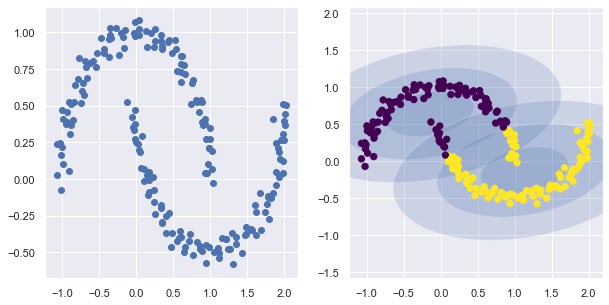

In [7]:
from sklearn.datasets import make_moons
Xmoon, ymoone = make_moons(200, noise=.05, random_state=0)

gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
figure, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(Xmoon[:, 0], Xmoon[:, 1])
plot_gmm(gmm2, Xmoon, ax=axes[1])

* AIC, BIC를 이용한 최적 GMM 선택(3)

In [8]:
AIC = []
BIC = []
max_components = 30
for comp in range(max_components):
    gmm = GaussianMixture(n_components=comp+1, random_state=0).fit(Xmoon)
    AIC.append(gmm.aic(Xmoon))
    BIC.append(gmm.bic(Xmoon))
    
(AIC.index(min(AIC)), BIC.index(min(BIC)))

(10, 5)

* AIC, BIC를 이용한 최적 GMM 선택(4)

Text(0.5, 1.0, 'GMM, n_components=10')

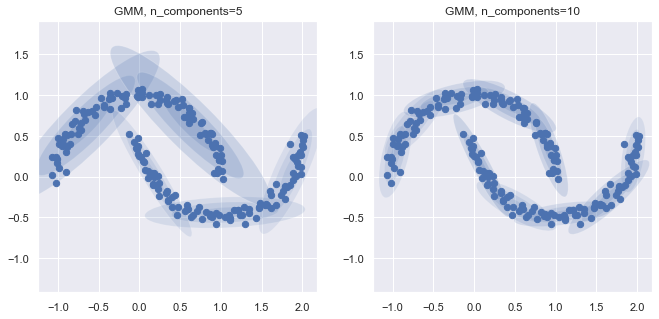

In [9]:
gmm5 = GaussianMixture(n_components=5, random_state=0)
gmm10 = GaussianMixture(n_components=10, random_state=0)
figure, axes = plt.subplots(1, 2, figsize=(11, 5))
plot_gmm(gmm5, Xmoon, label=False, ax=axes[0])
axes[0].set_title("GMM, n_components=5")
plot_gmm(gmm10, Xmoon, label=False, ax=axes[1])
axes[1].set_title("GMM, n_components=10")